<a href="https://colab.research.google.com/github/nkPit/nkPit/blob/hacks-ai/%D0%90%D0%BB%D1%82%D0%93%D0%A3_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Загрузим нужные библиотеки

In [ ]:
!pip install catboost
#!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.1 MB/s 


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

%matplotlib inline

### Считаем тренировочный набор

In [ ]:
df_issues_train = pd.read_csv("/content/train_issues.csv")
df_comment_train = pd.read_csv("/content/train_comments.csv")

df_emp = pd.read_csv("/content/employees.csv")

## Рассмотрим датасет по ближе

In [ ]:
df_issues_train.head(5)

,id,created,key,summary,project_id,assignee_id,creator_id,overall_worklogs
0,819952,2019-10-01 05:57:18.000,SM-10678,"UI тесты по заказу ""Добро КейДжи""",5,93,93,1800
1,819949,2019-10-01 05:59:45.000,SM-10679,"UI тесты раздела ""Профиль""",5,93,93,7200
2,819947,2019-10-01 06:00:38.000,SM-10680,"UI тесты раздела ""Личный счет""",5,93,93,14400
3,819943,2019-10-01 06:02:49.000,SM-10682,"UI тесты раздела ""Новости""",5,93,93,900
4,819941,2019-10-01 06:03:26.000,SM-10683,"UI тесты раздела ""Зоны скидок и доплат""",5,93,93,900


In [ ]:
df_issues_train.shape

(9589, 8)

In [ ]:
df_issues_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9589 entries, 0 to 9588
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                9589 non-null   int64 
 1   created           9589 non-null   object
 2   key               9589 non-null   object
 3   summary           9589 non-null   object
 4   project_id        9589 non-null   int64 
 5   assignee_id       9589 non-null   int64 
 6   creator_id        9589 non-null   int64 
 7   overall_worklogs  9589 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 599.4+ KB


In [ ]:
df_comment_train.head(3)

,comment_id,text,issue_id,author_id
0,11779,[https://www.youtube.com/watch?v=tuhOdtsvoNY|h...,669666,1
1,10601,OK [~accountid:557058:3f7ab89a-8969-4547-90df-...,669670,1
2,76101,I encountered a problem with access to `/users...,670930,2


In [ ]:
df_comment_train.shape

(13918, 4)

In [ ]:
df_comment_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13918 entries, 0 to 13917
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   comment_id  13918 non-null  int64 
 1   text        13918 non-null  object
 2   issue_id    13918 non-null  int64 
 3   author_id   13918 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 435.1+ KB


### Преобразование столбцов

Сделаем два столбца - день и месяц создания задачи

In [ ]:
df_issues_train["mounth"] = df_issues_train.created.map(lambda x : int(x.split("-")[1]))
df_issues_train["day"] = df_issues_train.created.map(lambda x : int(x.split("-")[2].split()[0]))

Удалим не нужную информацию о работниках

In [ ]:
df_emp = df_emp.drop(["active","full_name", "salary_calculation_type", "passport"],axis = 1)

Обьединим два набора данных по id исполнителя

In [ ]:
df_train = pd.merge(df_issues_train, df_emp, left_on="assignee_id", right_on="id", how='inner')

In [ ]:
df_train.shape

(9589, 19)

In [ ]:
df_train = df_train.fillna(0)

 Создадим список всех не числовых лейблов и взглянем на них

In [ ]:
mass_object = df_train.dtypes[df_train.dtypes == "object"].index.values

In [ ]:
df_train[mass_object].head(3)

,created,key,summary,position,hiring_type,payment_type,english_level
0,2019-10-01 05:57:18.000,SM-10678,"UI тесты по заказу ""Добро КейДжи""",Разработчик мобильных приложений,staff,fixed,0
1,2019-10-01 05:59:45.000,SM-10679,"UI тесты раздела ""Профиль""",Разработчик мобильных приложений,staff,fixed,0
2,2019-10-01 06:00:38.000,SM-10680,"UI тесты раздела ""Личный счет""",Разработчик мобильных приложений,staff,fixed,0


Взглянем на них поближе

In [ ]:
df_train.value_counts('position')

position
Web-разработчик                             6434
0                                           2235
Разработчик мобильных приложений             305
Системный администратор (DevOps инженер)     250
Менеджер проектов                            168
Директор по IT                                87
Web дизайнер                                  71
DevOps инженер                                29
Инженер тестировщик (QA engineer)              7
Delivery Manager                               2
Директор по стратегическому развитию           1
dtype: int64

In [ ]:
df_train['position'] = df_train['position'].replace(0, "неизвестно")

In [ ]:
df_train.value_counts('position')

position
Web-разработчик                             6434
неизвестно                                  2235
Разработчик мобильных приложений             305
Системный администратор (DevOps инженер)     250
Менеджер проектов                            168
Директор по IT                                87
Web дизайнер                                  71
DevOps инженер                                29
Инженер тестировщик (QA engineer)              7
Delivery Manager                               2
Директор по стратегическому развитию           1
dtype: int64

In [ ]:
import pandas as pd
from sklearn import preprocessing
le=preprocessing.LabelEncoder()
df_train['position']=le.fit_transform(df_train['position'].values)
df_train['position'].value_counts()

3     6434
10    2235
8      305
9      250
7      168
4       87
2       71
1       29
6        7
0        2
5        1
Name: position, dtype: int64

In [ ]:
df_train['position'] =df_train['position'].astype('float64')

In [ ]:
df_train['position'].value_counts()

3.0     6434
10.0    2235
8.0      305
9.0      250
7.0      168
4.0       87
2.0       71
1.0       29
6.0        7
0.0        2
5.0        1
Name: position, dtype: int64

In [ ]:
df_train.value_counts('summary').head(20)

summary
Test layout                                        34
Planing task                                       29
Planing tasks                                      24
Work on feedback                                   16
Fix bugs                                           11
Planing tasks                                      10
Planning                                            9
Test in different browsers                          8
Code refactoring                                    7
Planning                                            7
Task planning                                       6
Need to close slate in the process of deploy        6
Communications                                      6
Tasks planning                                      5
Dump from production                                5
Smoke test on staging                               5
Distributing methods according to the old logic     4
Communications and planning                         4
Unit-tests          

In [ ]:
df_train.loc[df_train["summary"].apply(lambda x: ("Plan" in x)), "summary"] = "plan"
df_train.loc[df_train["summary"].apply(lambda x: ("plan" in x)), "summary"] = "plan"
df_train.loc[df_train["summary"].apply(lambda x: ("План" in x)), "summary"] = "plan"
df_train.loc[df_train["summary"].apply(lambda x: ("план" in x)), "summary"] = "plan"

df_train.loc[df_train["summary"].apply(lambda x: ("Test" in x)), "summary"] = "test"
df_train.loc[df_train["summary"].apply(lambda x: ("test" in x)), "summary"] = "test"
df_train.loc[df_train["summary"].apply(lambda x: ("Тест" in x)), "summary"] = "test"
df_train.loc[df_train["summary"].apply(lambda x: ("тест" in x)), "summary"] = "test"
df_train.loc[df_train["summary"].apply(lambda x: ("Work" in x)), "summary"] = "work"
df_train.loc[df_train["summary"].apply(lambda x: ("work" in x)), "summary"] = "work"
df_train.loc[df_train["summary"].apply(lambda x: ("bug" in x)), "summary"] = "bug"
df_train.loc[df_train["summary"].apply(lambda x: ("Bug" in x)), "summary"] = "bug"
df_train.loc[df_train["summary"].apply(lambda x: ("Markup" in x)), "summary"] = "markup"
df_train.loc[df_train["summary"].apply(lambda x: ("markup" in x)), "summary"] = "markup"
df_train.loc[df_train["summary"].apply(lambda x: ("DB" in x)), "summary"] = "DB"
df_train.loc[df_train["summary"].apply(lambda x: ("Bd" in x)), "summary"] = "DB"
df_train.loc[df_train["summary"].apply(lambda x: ("bd" in x)), "summary"] = "DB"

df_train.loc[df_train["summary"].apply(lambda x: ("video" in x)), "summary"] = "video"
df_train.loc[df_train["summary"].apply(lambda x: ("Video" in x)), "summary"] = "video"
df_train.loc[df_train["summary"].apply(lambda x: ("Видео" in x)), "summary"] = "video"
df_train.loc[df_train["summary"].apply(lambda x: ("видео" in x)), "summary"] = "video"
df_train.loc[df_train["summary"].apply(lambda x: ("Fix" in x)), "summary"] = "fix"
df_train.loc[df_train["summary"].apply(lambda x: ("fix" in x)), "summary"] = "fix"
df_train.loc[df_train["summary"].apply(lambda x: ("прави" in x)), "summary"] = "fix"
df_train.loc[df_train["summary"].apply(lambda x: ("Прави" in x)), "summary"] = "fix"
df_train.loc[df_train["summary"].apply(lambda x: ("Правк" in x)), "summary"] = "fix"

df_train.loc[df_train["summary"].apply(lambda x: ("Измен" in x)), "summary"] = "fix"
df_train.loc[df_train["summary"].apply(lambda x: ("измен" in x)), "summary"] = "fix"
df_train.loc[df_train["summary"].apply(lambda x: ("Chang" in x)), "summary"] = "fix"
df_train.loc[df_train["summary"].apply(lambda x: ("сhang" in x)), "summary"] = "fix"
df_train.loc[df_train["summary"].apply(lambda x: ("Creat" in x)), "summary"] = "creat"
df_train.loc[df_train["summary"].apply(lambda x: ("Созда" in x)), "summary"] = "creat"
df_train.loc[df_train["summary"].apply(lambda x: ("созда" in x)), "summary"] = "creat"
df_train.loc[df_train["summary"].apply(lambda x: ("creat" in x)), "summary"] = "creat"
df_train.loc[df_train["summary"].apply(lambda x: ("add" in x)), "summary"] = "add"
df_train.loc[df_train["summary"].apply(lambda x: ("Add" in x)), "summary"] = "add"
df_train.loc[df_train["summary"].apply(lambda x: ("Добав" in x)), "summary"] = "add"
df_train.loc[df_train["summary"].apply(lambda x: ("добав" in x)), "summary"] = "add"
df_train.loc[df_train["summary"].apply(lambda x: ("Merg" in x)), "summary"] = "merg"
df_train.loc[df_train["summary"].apply(lambda x: ("merg" in x)), "summary"] = "merg"
df_train.loc[df_train["summary"].apply(lambda x: ("объед" in x)), "summary"] = "merge"
df_train.loc[df_train["summary"].apply(lambda x: ("Объед" in x)), "summary"] = "merge"
df_train.loc[df_train["summary"].apply(lambda x: ("Onboard" in x)), "summary"] = "onboard"
df_train.loc[df_train["summary"].apply(lambda x: ("onboard" in x)), "summary"] = "onboard"
df_train.loc[df_train["summary"].apply(lambda x: ("Онборд" in x)), "summary"] = "onboard"

df_train.loc[df_train["summary"].apply(lambda x: ("Page" in x)), "summary"] = "page"
df_train.loc[df_train["summary"].apply(lambda x: ("page" in x)), "summary"] = "page"
df_train.loc[df_train["summary"].apply(lambda x: ("страни" in x)), "summary"] = "page"
df_train.loc[df_train["summary"].apply(lambda x: ("Страни" in x)), "summary"] = "page"
df_train.loc[df_train["summary"].apply(lambda x: ("Commun" in x)), "summary"] = "commun"
df_train.loc[df_train["summary"].apply(lambda x: ("commun" in x)), "summary"] = "commun"
df_train.loc[df_train["summary"].apply(lambda x: ("logic" in x)), "summary"] = "logic"
df_train.loc[df_train["summary"].apply(lambda x: ("Logic" in x)), "summary"] = "logic"
df_train.loc[df_train["summary"].apply(lambda x: ("Логи" in x)), "summary"] = "logic"
df_train.loc[df_train["summary"].apply(lambda x: ("логи" in x)), "summary"] = "logic"
df_train.loc[df_train["summary"].apply(lambda x: ("Review" in x)), "summary"] = "review"
df_train.loc[df_train["summary"].apply(lambda x: ("review" in x)), "summary"] = "review"
df_train.loc[df_train["summary"].apply(lambda x: ("Teach" in x)), "summary"] = "teach"
df_train.loc[df_train["summary"].apply(lambda x: ("teach" in x)), "summary"] = "teach"
df_train.loc[df_train["summary"].apply(lambda x: ("Student" in x)), "summary"] = "student"
df_train.loc[df_train["summary"].apply(lambda x: ("student" in x)), "summary"] = "student"
df_train.loc[df_train["summary"].apply(lambda x: ("Update" in x)), "summary"] = "update"
df_train.loc[df_train["summary"].apply(lambda x: ("update" in x)), "summary"] = "update"
df_train.loc[df_train["summary"].apply(lambda x: ("Обнов" in x)), "summary"] = "update"
df_train.loc[df_train["summary"].apply(lambda x: ("обнов" in x)), "summary"] = "update"
df_train.loc[df_train["summary"].apply(lambda x: ("refact" in x)), "summary"] = "refact"
df_train.loc[df_train["summary"].apply(lambda x: ("Refact" in x)), "summary"] = "refact"
df_train.loc[df_train["summary"].apply(lambda x: ("рефакт" in x)), "summary"] = "refact"
df_train.loc[df_train["summary"].apply(lambda x: ("Рефакт" in x)), "summary"] = "refact"
df_train.loc[df_train["summary"].apply(lambda x: ("изучи" in x)), "summary"] = "study"
df_train.loc[df_train["summary"].apply(lambda x: ("Изучи" in x)), "summary"] = "study"
df_train.loc[df_train["summary"].apply(lambda x: ("Study" in x)), "summary"] = "study"
df_train.loc[df_train["summary"].apply(lambda x: ("study" in x)), "summary"] = "study"
df_train.loc[df_train["summary"].apply(lambda x: ("Fronte" in x)), "summary"] = "fronte"
df_train.loc[df_train["summary"].apply(lambda x: ("fronte" in x)), "summary"] = "fronte"
df_train.loc[df_train["summary"].apply(lambda x: ("Интерф" in x)), "summary"] = "fronte"
df_train.loc[df_train["summary"].apply(lambda x: ("интерф" in x)), "summary"] = "fronte"
df_train.loc[df_train["summary"].apply(lambda x: ("Imag" in x)), "summary"] = "imag"
df_train.loc[df_train["summary"].apply(lambda x: ("imag" in x)), "summary"] = "imag"
df_train.loc[df_train["summary"].apply(lambda x: ("Изобра" in x)), "summary"] = "imag"
df_train.loc[df_train["summary"].apply(lambda x: ("изобра" in x)), "summary"] = "imag"


In [ ]:
df_train.value_counts('summary').head(50)

summary
add                                                           960
test                                                          764
creat                                                         556
fix                                                           504
page                                                          368
markup                                                        327
work                                                          315
bug                                                           256
teach                                                         251
plan                                                          236
update                                                        195
logic                                                         185
student                                                       179
video                                                         129
refact                                                         93
fr

In [ ]:
other_meaning = set(["Plan", "plan", "План", "план",
          "Test", "test", "Тест", "тест",
          "Work", "work", 
          "bug", "Bug", 
          "Markup", "markup", 
          "DB", "bd", "Bd",
          "video", "Video", "Видео", "видео",
          "Fix", "fix", "прави", "Прави", "Правк", "Измен", "измен", "Chang", "сhang",
          "Creat", "creat", "Созда", "созда",
          "add", "Add", "Добав", "добав",  
          "Merg", "merg", "объед", "Объед", 
          "Onboard" "onboard", "Онборд",
          "Page", "page", "страни" , "Страни", 
          "Commun" , "commun", 
          "logic", "Logic", "логи", "Логи", 
          "Review", "review", 
          "Teach", "teach", 
          "Student", "student", 
          "Update", "update", "Обнов", "обнов" , 
          "refact", "Refact", "рефакт", "Рефакт",
          "изучи", "Изучи", "Study", "study"
          "Fronte", "fronte", "Интерф", "интерф",                   
          "Imag", "imag", "Изобра", "изобра"])

In [ ]:
df_train.loc[~df_train["summary"].isin(other_meaning), "summary"] = "other_meaning"

In [ ]:
df_train.value_counts('summary').head(25)

summary
other_meaning    3924
add               960
test              764
creat             556
fix               504
page              368
markup            327
work              315
bug               256
teach             251
plan              236
update            195
logic             185
student           179
video             129
refact             93
fronte             89
review             85
imag               84
DB                 37
merg               35
commun             17
dtype: int64

In [ ]:
df_train.value_counts('key').head(20)

key
ADBK-138     2
ADBK-145     2
ADBK-86      2
ADBK-141     2
ADBK-211     2
ADBK-89      2
ADBK-109     2
ADBK-110     2
ADBK-112     2
ADBK-114     2
ADBK-137     2
ADBK-92      2
ADBK-144     2
BALT-7704    1
BALT-7705    1
ADBK-1       1
BALT-7706    1
BALT-7708    1
BALT-7712    1
BALT-7713    1
dtype: int64

In [ ]:
df_train.loc[df_train["key"].apply(lambda x: ("ADBK" in x)), "key"] = "ADBK"
df_train.loc[df_train["key"].apply(lambda x: ("BALT" in x)), "key"] = "BALT"
df_train.loc[df_train["key"].apply(lambda x: ("UN" in x)), "key"] = "UN"
df_train.loc[df_train["key"].apply(lambda x: ("XXO" in x)), "key"] = "XXO"
df_train.loc[df_train["key"].apply(lambda x: ("BA" in x)), "key"] = "BA"
df_train.loc[df_train["key"].apply(lambda x: ("FPY" in x)), "key"] = "FPY"
df_train.loc[df_train["key"].apply(lambda x: ("LJ" in x)), "key"] = "LJ"
df_train.loc[df_train["key"].apply(lambda x: ("SM" in x)), "key"] = "SM"

In [ ]:
df_train.value_counts('key').head(20)

key
BA      6951
ADBK     676
FPY      642
XXO      519
UN       498
SM       299
LJ         4
dtype: int64

In [ ]:
df_train.hiring_type.value_counts()

staff        7005
0            1959
non_staff     625
Name: hiring_type, dtype: int64

In [ ]:
df_train.payment_type.value_counts()

fixed     5765
0         2060
hourly    1764
Name: payment_type, dtype: int64

In [ ]:
df_train.english_level.value_counts()

0     9055
B1     358
C1     176
Name: english_level, dtype: int64

Сменим им тип данных

In [ ]:
df_train["payment_type"] = pd.Categorical(df_train["payment_type"])
df_train["payment_type"].astype('category').cat.codes
df_train["payment_type"] = df_train["payment_type"].cat.codes

In [ ]:
df_train["hiring_type"] = pd.Categorical(df_train["hiring_type"])
df_train["hiring_type"].astype('category').cat.codes
df_train["hiring_type"] = df_train["hiring_type"].cat.codes

In [ ]:
df_train["english_level"] = pd.Categorical(df_train["english_level"])
df_train["english_level"].astype('category').cat.codes
df_train["english_level"] = df_train["english_level"].cat.codes

In [ ]:
df_train["key"] = pd.Categorical(df_train["key"])
df_train["key"].astype('category').cat.codes
df_train["key"] = df_train["key"].cat.codes

In [ ]:
df_train["summary"] = pd.Categorical(df_train["summary"])
df_train["summary"].astype('category').cat.codes
df_train["summary"] = df_train["summary"].cat.codes

In [ ]:
df_train.value_counts('key').head(20)

key
1    6951
0     676
2     642
6     519
5     498
4     299
3       4
dtype: int64

In [ ]:
df_train.value_counts('summary').head(25)

summary
11    3924
1      960
18     764
4      556
5      504
12     368
9      327
21     315
2      256
17     251
13     236
19     195
8      185
16     179
20     129
14      93
6       89
15      85
7       84
0       37
10      35
3       17
dtype: int64

Распределение различных значений

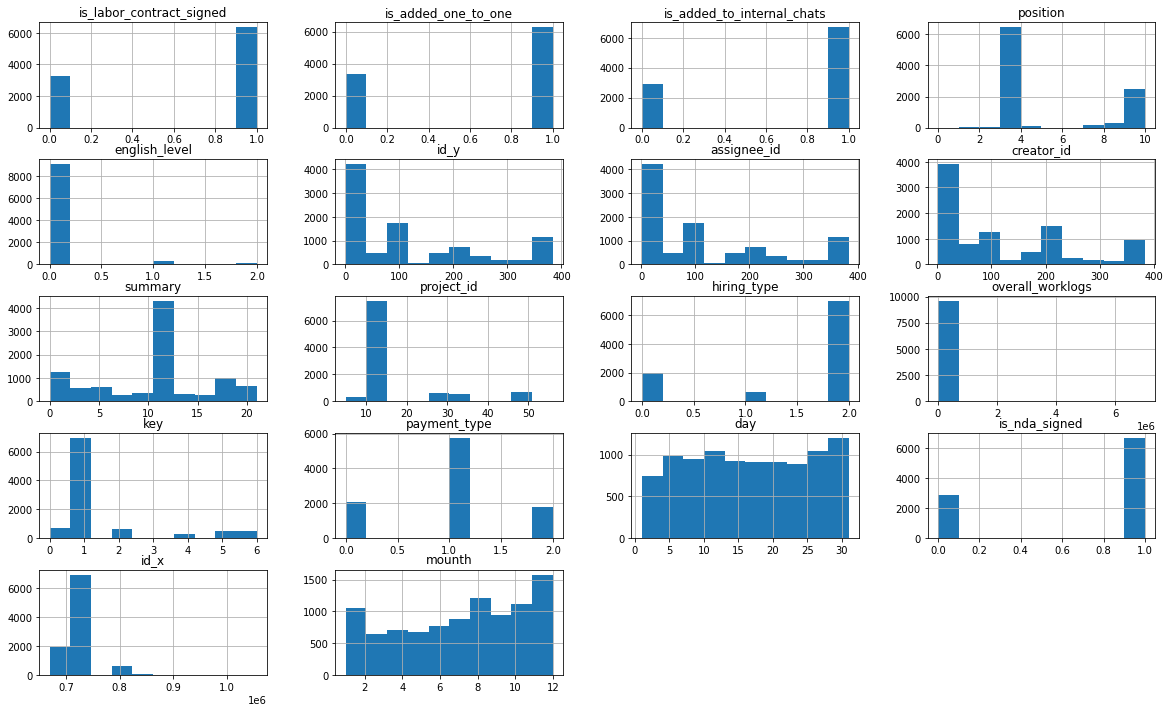

In [ ]:
mass_object = df_train.dtypes[df_train.dtypes == "object"].index.values
features = list(set(df_train.columns.to_list()) - set(mass_object))

_ = df_train[features].hist(figsize=(20,12))

Рассмторим корреляцию всех признаков

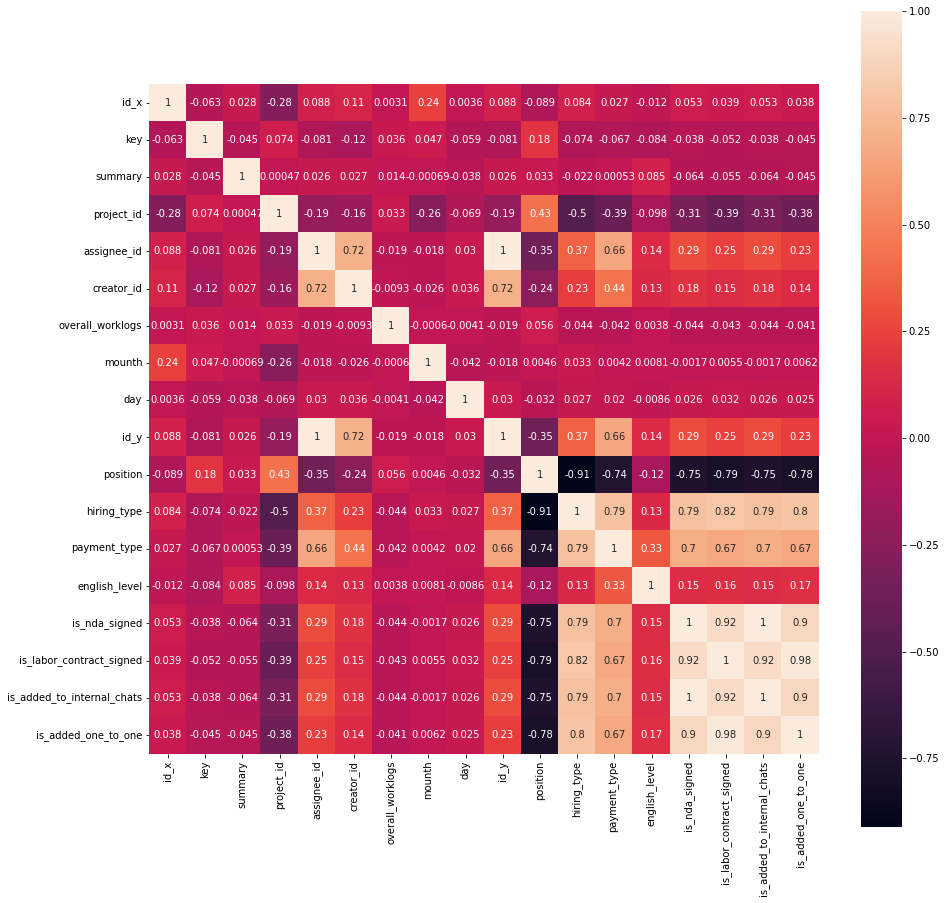

In [ ]:
plt.rcParams['figure.figsize']=(15,15)

corr = df_train.corr()
g = sns.heatmap(corr, square = True, annot=True)

## Выделим выборки

Удалим все лишние столбцы из выборки

In [ ]:
mass_object = df_train.dtypes[df_train.dtypes == "object"].index.values

In [ ]:
mass_object

array(['created'], dtype=object)

In [ ]:
stuff = ["id_x","id_y","overall_worklogs"]

mass_object = np.append(mass_object, stuff)

In [ ]:
mass_object.shape

(4,)

In [ ]:
X = df_train.drop(mass_object, axis = 1)

In [ ]:
y = df_train[["overall_worklogs"]]

In [ ]:
X

,key,summary,project_id,assignee_id,creator_id,mounth,day,position,hiring_type,payment_type,english_level,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one
0,4,18,5,93,93,10,1,8.0,2,1,0,1,1,1,1
1,4,18,5,93,93,10,1,8.0,2,1,0,1,1,1,1
2,4,18,5,93,93,10,1,8.0,2,1,0,1,1,1,1
3,4,18,5,93,93,10,1,8.0,2,1,0,1,1,1,1
4,4,18,5,93,93,10,1,8.0,2,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9584,6,12,33,98,58,1,24,3.0,2,1,0,1,1,1,1
9585,3,11,56,2,2,6,2,3.0,2,1,0,0,0,0,0
9586,3,11,56,2,2,6,5,3.0,2,1,0,0,0,0,0
9587,3,17,56,2,2,6,5,3.0,2,1,0,0,0,0,0


In [ ]:
X.head(3)

,key,summary,project_id,assignee_id,creator_id,mounth,day,position,hiring_type,payment_type,english_level,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one
0,4,18,5,93,93,10,1,8.0,2,1,0,1,1,1,1
1,4,18,5,93,93,10,1,8.0,2,1,0,1,1,1,1
2,4,18,5,93,93,10,1,8.0,2,1,0,1,1,1,1


In [ ]:
X.shape

(9589, 15)

In [ ]:
y

,overall_worklogs
0,1800
1,7200
2,14400
3,900
4,900
...,...
9584,18000
9585,16200
9586,3600
9587,6300


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Обучение модели

*******************


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from catboost import CatBoostRegressor


In [ ]:
estimators = [('ridge', RidgeCV()), ('lasso', LassoCV(random_state=42)), ('svr', LinearSVR(random_state=42)), ('knr', KNeighborsRegressor(n_neighbors=25, metric='euclidean'))]

In [ ]:
final_layer_rfr = RandomForestRegressor(n_estimators=1000, max_depth=25, min_samples_split=200, max_features=3, max_leaf_nodes=3, random_state=42)
final_layer_gbr = GradientBoostingRegressor(n_estimators=2000, max_features=3, max_leaf_nodes=3,random_state=42)
final_layer_cat = CatBoostRegressor(n_estimators = 1000, learning_rate = 0.09, max_depth=6, random_state=42)

final_layer = StackingRegressor(estimators=[('rf', final_layer_rfr), ('cat', final_layer_cat), ('gbrt', final_layer_gbr)], final_estimator=RidgeCV())
multi_layer_regressor = StackingRegressor(estimators=[('ridge', RidgeCV()), ('lasso', LassoCV(random_state=42)), ('svr', LinearSVR(random_state=42)), ('knr', KNeighborsRegressor(n_neighbors=25, metric='euclidean'))], final_estimator=final_layer)


In [ ]:
multi_layer_regressor.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_stacking.py:758: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Выходные данные были обрезаны до нескольких последних строк (5000).
0:	learn: 62948.7222001	total: 5.53ms	remaining: 5.52s
1:	learn: 62773.3479540	total: 12.9ms	remaining: 6.45s
2:	learn: 62484.2270073	total: 16.3ms	remaining: 5.41s
3:	learn: 62243.6825716	total: 22.4ms	remaining: 5.57s
4:	learn: 61869.4226198	total: 31.5ms	remaining: 6.26s
5:	learn: 61604.0694393	total: 34.6ms	remaining: 5.73s
6:	learn: 61425.2571326	total: 40.8ms	remaining: 5.78s
7:	learn: 61150.6740907	total: 46.8ms	remaining: 5.81s
8:	learn: 60918.3143065	total: 52.8ms	remaining: 5.81s
9:	learn: 60703.6086606	total: 55.6ms	remaining: 5.5s
10:	learn: 60438.2889778	total: 58.3ms	remaining: 5.24s
11:	learn: 60301.5249363	total: 60.6ms	remaining: 4.99s
12:	learn: 59726.0296594	total: 63.6ms	remaining: 4.83s
13:	learn: 59581.7914066	total: 65.8ms	remaining: 4.63s
14:	learn: 59445.0447901	total: 68.8ms	remaining: 4.51s
15:	learn: 59358.3502678	total: 71.1ms	remaining: 4.37s
16:	learn: 59267.7753276	total: 74.1ms	remainin

StackingRegressor(estimators=[('ridge',
                               RidgeCV(alphas=array([ 0.1,  1. , 10. ]))),
                              ('lasso', LassoCV(random_state=42)),
                              ('svr', LinearSVR(random_state=42)),
                              ('knr',
                               KNeighborsRegressor(metric='euclidean',
                                                   n_neighbors=25))],
                  final_estimator=StackingRegressor(estimators=[('rf',
                                                                 RandomForestRegressor(max_depth=25,
                                                                                       max_features=3,
                                                                                       max_leaf_nodes=3,
                                                                                       min_samples_split=200,
                                                                                  

## Оценка точности

***************


In [ ]:
pred = multi_layer_regressor.predict(X_test)

In [ ]:
from sklearn.metrics import r2_score

score = r2_score(y_test, pred)

In [ ]:
score 

0.007725023171407663

*******

# Cоздание файла с ответом

In [ ]:
df_issues_test = pd.read_csv("/content/test_issues.csv")
df_comment_test = pd.read_csv("/content/test_comments.csv")
df_submission = pd.read_csv("/content/sample_solution.csv")

Провем те же манипуляции с данными что и на обучении

In [ ]:
df_issues_test.head(5)

,id,created,key,summary,project_id,assignee_id,creator_id
0,675975,2020-01-15 09:52:57.000,SM-11140,Выгрузить все mp3 файлы звонков на диск,5,112,112
1,675972,2020-01-15 09:54:35.000,SM-11141,Удалить файлы mp3 звонков с сервера до 01.01.2019,5,112,112
2,675965,2020-01-16 04:46:17.000,SM-11144,Удалить окно выбора тарифов и перенести функци...,5,94,54
3,675961,2020-01-16 11:12:18.000,SM-11146,При авторизации пользователь/водитель не видит...,5,94,94
4,675955,2020-01-17 05:19:39.000,SM-11150,Основные проблемы по корп. отделу (по состояни...,5,1,54


In [ ]:
df_issues_test.shape

(1070, 7)

In [ ]:
df_issues_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1070 non-null   int64 
 1   created      1070 non-null   object
 2   key          1070 non-null   object
 3   summary      1070 non-null   object
 4   project_id   1070 non-null   int64 
 5   assignee_id  1070 non-null   int64 
 6   creator_id   1070 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 58.6+ KB


In [ ]:
df_comment_train.head(3)

,comment_id,text,issue_id,author_id
0,11779,[https://www.youtube.com/watch?v=tuhOdtsvoNY|h...,669666,1
1,10601,OK [~accountid:557058:3f7ab89a-8969-4547-90df-...,669670,1
2,76101,I encountered a problem with access to `/users...,670930,2


In [ ]:
df_comment_test.shape

(1348, 4)

In [ ]:
df_comment_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348 entries, 0 to 1347
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   comment_id  1348 non-null   int64 
 1   text        1348 non-null   object
 2   issue_id    1348 non-null   int64 
 3   author_id   1348 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 42.2+ KB


In [ ]:
df_issues_test["mounth"] = df_issues_test.created.map(lambda x : int(x.split("-")[1]))
df_issues_test["day"] = df_issues_test.created.map(lambda x : int(x.split("-")[2].split()[0]))

In [ ]:
df_test = pd.merge(df_issues_test, df_emp, left_on="assignee_id", right_on="id", how='inner')

In [ ]:
df_test.shape

(1070, 18)

In [ ]:
df_test.value_counts('position')

position
Web-разработчик                             707
Системный администратор (DevOps инженер)     35
DevOps инженер                               25
Web дизайнер                                 22
Менеджер проектов                            12
Разработчик мобильных приложений              5
dtype: int64

In [ ]:
df_test['position'] = (df_test['position'].replace({'Web-разработчик': 3, 'Системный администратор (DevOps инженер)': 9, "DevOps инженер" : 1, "Web дизайнер" : 2, "Менеджер проектов" : 7, "Разработчик мобильных приложений" : 8}))

In [ ]:
df_test.value_counts('position')

position
3.0    707
9.0     35
1.0     25
2.0     22
7.0     12
8.0      5
dtype: int64

In [ ]:
df_test.loc[df_test["key"].apply(lambda x: ("ADBK" in x)), "key"] = "ADBK"
df_test.loc[df_test["key"].apply(lambda x: ("BA" in x)), "key"] = "BA"
df_test.loc[df_test["key"].apply(lambda x: ("FPY" in x)), "key"] = "FPY"
df_test.loc[df_test["key"].apply(lambda x: ("XXO" in x)), "key"] = "XXO"
df_test.loc[df_test["key"].apply(lambda x: ("UN" in x)), "key"] = "UN"
df_test.loc[df_test["key"].apply(lambda x: ("SM" in x)), "key"] = "SM"
df_test.loc[df_test["key"].apply(lambda x: ("LJ" in x)), "key"] = "LJ"

In [ ]:
df_test.value_counts('key')

key
BA      773
ADBK     76
FPY      72
XXO      58
UN       56
SM       34
LJ        1
dtype: int64

In [ ]:
df_test.value_counts('summary').head(20)

summary
Investigate the task                                                                 5
Develop the markup of the page                                                       2
Deploy EVN and ETL                                                                   2
Add JSDoc descriptions                                                               2
UserController.php                                                                   2
Refactor class components to functional                                              2
Add unit tests                                                                       2
Коммуникации Гаухар                                                                  2
Unit tests                                                                           2
Show screen on Free plan when teacher starts live lesson + prompt with whiteboard    1
Set lesson background from recent                                                    1
SMSs have not been sent to customer

In [ ]:
df_test.loc[df_test["summary"].apply(lambda x: ("Plan" in x)), "summary"] = "plan"
df_test.loc[df_test["summary"].apply(lambda x: ("plan" in x)), "summary"] = "plan"
df_test.loc[df_test["summary"].apply(lambda x: ("План" in x)), "summary"] = "plan"
df_test.loc[df_test["summary"].apply(lambda x: ("план" in x)), "summary"] = "plan"

df_test.loc[df_test["summary"].apply(lambda x: ("Test" in x)), "summary"] = "test"
df_test.loc[df_test["summary"].apply(lambda x: ("test" in x)), "summary"] = "test"
df_test.loc[df_test["summary"].apply(lambda x: ("Тест" in x)), "summary"] = "test"
df_test.loc[df_test["summary"].apply(lambda x: ("тест" in x)), "summary"] = "test"
df_test.loc[df_test["summary"].apply(lambda x: ("Work" in x)), "summary"] = "work"
df_test.loc[df_test["summary"].apply(lambda x: ("work" in x)), "summary"] = "work"
df_test.loc[df_test["summary"].apply(lambda x: ("bug" in x)), "summary"] = "bug"
df_test.loc[df_test["summary"].apply(lambda x: ("Bug" in x)), "summary"] = "bug"
df_test.loc[df_test["summary"].apply(lambda x: ("Markup" in x)), "summary"] = "markup"
df_test.loc[df_test["summary"].apply(lambda x: ("markup" in x)), "summary"] = "markup"
df_test.loc[df_test["summary"].apply(lambda x: ("DB" in x)), "summary"] = "DB"
df_test.loc[df_test["summary"].apply(lambda x: ("bd" in x)), "summary"] = "DB"
df_test.loc[df_test["summary"].apply(lambda x: ("Bd" in x)), "summary"] = "DB"

df_test.loc[df_test["summary"].apply(lambda x: ("video" in x)), "summary"] = "video"
df_test.loc[df_test["summary"].apply(lambda x: ("Video" in x)), "summary"] = "video"
df_test.loc[df_test["summary"].apply(lambda x: ("Видео" in x)), "summary"] = "video"
df_test.loc[df_test["summary"].apply(lambda x: ("видео" in x)), "summary"] = "video"
df_test.loc[df_test["summary"].apply(lambda x: ("Fix" in x)), "summary"] = "fix"
df_test.loc[df_test["summary"].apply(lambda x: ("fix" in x)), "summary"] = "fix"
df_test.loc[df_test["summary"].apply(lambda x: ("прави" in x)), "summary"] = "fix"
df_test.loc[df_test["summary"].apply(lambda x: ("Прави" in x)), "summary"] = "fix"
df_test.loc[df_test["summary"].apply(lambda x: ("Правк" in x)), "summary"] = "fix"

df_test.loc[df_test["summary"].apply(lambda x: ("Измен" in x)), "summary"] = "fix"
df_test.loc[df_test["summary"].apply(lambda x: ("измен" in x)), "summary"] = "fix"
df_test.loc[df_test["summary"].apply(lambda x: ("Chang" in x)), "summary"] = "fix"
df_test.loc[df_test["summary"].apply(lambda x: ("сhang" in x)), "summary"] = "fix"
df_test.loc[df_test["summary"].apply(lambda x: ("Creat" in x)), "summary"] = "creat"
df_test.loc[df_test["summary"].apply(lambda x: ("Созда" in x)), "summary"] = "creat"
df_test.loc[df_test["summary"].apply(lambda x: ("созда" in x)), "summary"] = "creat"
df_test.loc[df_test["summary"].apply(lambda x: ("creat" in x)), "summary"] = "creat"
df_test.loc[df_test["summary"].apply(lambda x: ("add" in x)), "summary"] = "add"
df_test.loc[df_test["summary"].apply(lambda x: ("Add" in x)), "summary"] = "add"
df_test.loc[df_test["summary"].apply(lambda x: ("Добав" in x)), "summary"] = "add"
df_test.loc[df_test["summary"].apply(lambda x: ("добав" in x)), "summary"] = "add"
df_test.loc[df_test["summary"].apply(lambda x: ("Merg" in x)), "summary"] = "merg"
df_test.loc[df_test["summary"].apply(lambda x: ("merg" in x)), "summary"] = "merg"
df_test.loc[df_test["summary"].apply(lambda x: ("объед" in x)), "summary"] = "merge"
df_test.loc[df_test["summary"].apply(lambda x: ("Объед" in x)), "summary"] = "merge"
df_test.loc[df_test["summary"].apply(lambda x: ("Onboard" in x)), "summary"] = "onboard"
df_test.loc[df_test["summary"].apply(lambda x: ("onboard" in x)), "summary"] = "onboard"
df_test.loc[df_test["summary"].apply(lambda x: ("Онборд" in x)), "summary"] = "onboard"

df_test.loc[df_test["summary"].apply(lambda x: ("Page" in x)), "summary"] = "page"
df_test.loc[df_test["summary"].apply(lambda x: ("page" in x)), "summary"] = "page"
df_test.loc[df_test["summary"].apply(lambda x: ("страни" in x)), "summary"] = "page"
df_test.loc[df_test["summary"].apply(lambda x: ("Страни" in x)), "summary"] = "page"
df_test.loc[df_test["summary"].apply(lambda x: ("Commun" in x)), "summary"] = "commun"
df_test.loc[df_test["summary"].apply(lambda x: ("commun" in x)), "summary"] = "commun"
df_test.loc[df_test["summary"].apply(lambda x: ("logic" in x)), "summary"] = "logic"
df_test.loc[df_test["summary"].apply(lambda x: ("Logic" in x)), "summary"] = "logic"
df_test.loc[df_test["summary"].apply(lambda x: ("Логи" in x)), "summary"] = "logic"
df_test.loc[df_test["summary"].apply(lambda x: ("логи" in x)), "summary"] = "logic"
df_test.loc[df_test["summary"].apply(lambda x: ("Review" in x)), "summary"] = "review"
df_test.loc[df_test["summary"].apply(lambda x: ("review" in x)), "summary"] = "review"
df_test.loc[df_test["summary"].apply(lambda x: ("Teach" in x)), "summary"] = "teach"
df_test.loc[df_test["summary"].apply(lambda x: ("teach" in x)), "summary"] = "teach"
df_test.loc[df_test["summary"].apply(lambda x: ("Student" in x)), "summary"] = "student"
df_test.loc[df_test["summary"].apply(lambda x: ("student" in x)), "summary"] = "student"
df_test.loc[df_test["summary"].apply(lambda x: ("Update" in x)), "summary"] = "update"
df_test.loc[df_test["summary"].apply(lambda x: ("update" in x)), "summary"] = "update"
df_test.loc[df_test["summary"].apply(lambda x: ("Обнов" in x)), "summary"] = "update"
df_test.loc[df_test["summary"].apply(lambda x: ("обнов" in x)), "summary"] = "update"
df_test.loc[df_test["summary"].apply(lambda x: ("refact" in x)), "summary"] = "refact"
df_test.loc[df_test["summary"].apply(lambda x: ("Refact" in x)), "summary"] = "refact"
df_test.loc[df_test["summary"].apply(lambda x: ("рефакт" in x)), "summary"] = "refact"
df_test.loc[df_test["summary"].apply(lambda x: ("Рефакт" in x)), "summary"] = "refact"
df_test.loc[df_test["summary"].apply(lambda x: ("изучи" in x)), "summary"] = "study"
df_test.loc[df_test["summary"].apply(lambda x: ("Изучи" in x)), "summary"] = "study"
df_test.loc[df_test["summary"].apply(lambda x: ("Study" in x)), "summary"] = "study"
df_test.loc[df_test["summary"].apply(lambda x: ("study" in x)), "summary"] = "study"
df_test.loc[df_test["summary"].apply(lambda x: ("Fronte" in x)), "summary"] = "fronte"
df_test.loc[df_test["summary"].apply(lambda x: ("fronte" in x)), "summary"] = "fronte"
df_test.loc[df_test["summary"].apply(lambda x: ("Интерф" in x)), "summary"] = "fronte"
df_test.loc[df_test["summary"].apply(lambda x: ("интерф" in x)), "summary"] = "fronte"
df_test.loc[df_test["summary"].apply(lambda x: ("Imag" in x)), "summary"] = "imag"
df_test.loc[df_test["summary"].apply(lambda x: ("imag" in x)), "summary"] = "imag"
df_test.loc[df_test["summary"].apply(lambda x: ("Изобра" in x)), "summary"] = "imag"
df_test.loc[df_test["summary"].apply(lambda x: ("изобра" in x)), "summary"] = "imag"


In [ ]:
df_test.loc[~df_test["summary"].isin(other_meaning), "summary"] = "other_meaning"

In [ ]:
df_test.value_counts('summary').head(50)

summary
other_meaning    455
add               90
test              74
fix               59
teach             54
page              50
student           43
markup            40
work              32
update            30
creat             28
bug               22
logic             21
plan              16
review            13
imag              11
fronte            11
refact             8
video              8
merg               2
commun             2
DB                 1
dtype: int64

In [ ]:
df_test = df_test.fillna(0)

In [ ]:
mass_object = df_test.dtypes[df_test.dtypes == "object"].index.values

In [ ]:
df_test[mass_object].head(3)

,created,key,summary,hiring_type,payment_type,english_level
0,2020-01-15 09:52:57.000,SM,other_meaning,staff,fixed,0
1,2020-01-15 09:54:35.000,SM,other_meaning,staff,fixed,0
2,2020-02-01 02:24:11.000,SM,other_meaning,staff,fixed,0


In [ ]:
df_test.hiring_type.value_counts()

staff        767
0            158
non_staff    145
Name: hiring_type, dtype: int64

In [ ]:
df_test.payment_type.value_counts()

fixed     698
hourly    201
0         171
Name: payment_type, dtype: int64

In [ ]:
df_test.english_level.value_counts()

0     1033
B1      26
C1      11
Name: english_level, dtype: int64

In [ ]:
df_test["payment_type"] = pd.Categorical(df_test["payment_type"])
df_test["payment_type"].astype('category').cat.codes
df_test["payment_type"] = df_test["payment_type"].cat.codes

In [ ]:
df_test["hiring_type"] = pd.Categorical(df_test["hiring_type"])
df_test["hiring_type"].astype('category').cat.codes
df_test["hiring_type"] = df_test["hiring_type"].cat.codes

In [ ]:
df_test["english_level"] = pd.Categorical(df_test["english_level"])
df_test["english_level"].astype('category').cat.codes
df_test["english_level"] = df_test["english_level"].cat.codes

In [ ]:
df_test["key"] = pd.Categorical(df_test["key"])
df_test["key"].astype('category').cat.codes
df_test["key"] = df_test["key"].cat.codes

In [ ]:
df_test["summary"] = pd.Categorical(df_test["summary"])
df_test["summary"].astype('category').cat.codes
df_test["summary"] = df_test["summary"].cat.codes

In [ ]:
df_test

,id_x,created,key,summary,project_id,assignee_id,creator_id,mounth,day,id_y,position,hiring_type,payment_type,english_level,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one
0,675975,2020-01-15 09:52:57.000,4,11,5,112,112,1,15,112,1.0,2,1,0,0,0,0,0
1,675972,2020-01-15 09:54:35.000,4,11,5,112,112,1,15,112,1.0,2,1,0,0,0,0,0
2,675917,2020-02-01 02:24:11.000,4,11,5,112,1,2,1,112,1.0,2,1,0,0,0,0,0
3,675915,2020-02-01 02:27:30.000,4,11,5,112,1,2,1,112,1.0,2,1,0,0,0,0,0
4,675912,2020-02-03 05:05:30.000,4,1,5,112,1,2,3,112,1.0,2,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,2176348,2021-07-15 12:41:44.073,2,11,29,191,191,7,15,191,3.0,2,2,2,1,1,1,1
1066,2176673,2021-07-15 16:32:59.368,2,11,29,191,192,7,15,191,3.0,2,2,2,1,1,1,1
1067,686533,2020-09-07 11:17:29.000,6,4,33,246,58,9,7,246,2.0,2,2,0,1,1,1,1
1068,686395,2020-10-27 08:16:40.000,6,11,33,13,58,10,27,13,8.0,2,1,0,1,1,1,1


In [ ]:
mass_object = df_test.dtypes[df_test.dtypes == "object"].index.values

In [ ]:
mass_object

array(['created'], dtype=object)

In [ ]:
stuff = ["id_x","id_y"]
mass_object = np.append(mass_object, stuff)

In [ ]:
df_test_1 = df_test.drop(mass_object, axis = 1)

In [ ]:
df_test_1

,key,summary,project_id,assignee_id,creator_id,mounth,day,position,hiring_type,payment_type,english_level,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one
0,4,11,5,112,112,1,15,1.0,2,1,0,0,0,0,0
1,4,11,5,112,112,1,15,1.0,2,1,0,0,0,0,0
2,4,11,5,112,1,2,1,1.0,2,1,0,0,0,0,0
3,4,11,5,112,1,2,1,1.0,2,1,0,0,0,0,0
4,4,1,5,112,1,2,3,1.0,2,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,2,11,29,191,191,7,15,3.0,2,2,2,1,1,1,1
1066,2,11,29,191,192,7,15,3.0,2,2,2,1,1,1,1
1067,6,4,33,246,58,9,7,2.0,2,2,0,1,1,1,1
1068,6,11,33,13,58,10,27,8.0,2,1,0,1,1,1,1


In [ ]:
df_test_1 = df_test_1.fillna(0)

In [ ]:
df_test_1

,key,summary,project_id,assignee_id,creator_id,mounth,day,position,hiring_type,payment_type,english_level,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one
0,4,11,5,112,112,1,15,1.0,2,1,0,0,0,0,0
1,4,11,5,112,112,1,15,1.0,2,1,0,0,0,0,0
2,4,11,5,112,1,2,1,1.0,2,1,0,0,0,0,0
3,4,11,5,112,1,2,1,1.0,2,1,0,0,0,0,0
4,4,1,5,112,1,2,3,1.0,2,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,2,11,29,191,191,7,15,3.0,2,2,2,1,1,1,1
1066,2,11,29,191,192,7,15,3.0,2,2,2,1,1,1,1
1067,6,4,33,246,58,9,7,2.0,2,2,0,1,1,1,1
1068,6,11,33,13,58,10,27,8.0,2,1,0,1,1,1,1


In [ ]:
df_test_pred = multi_layer_regressor.predict(df_test_1)
df_test_pred = (df_test_pred).astype('int64')

In [ ]:
df_submission["overall_worklogs"] = df_test_pred
df_submission.head(4)

,id,overall_worklogs
0,675975,18835
1,675972,18835
2,675965,15488
3,675961,15488


In [ ]:
df_submission.to_csv("/content/solution.csv", index=False)